In [1]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
import re
import contractions
from collections import Counter
import matplotlib.pyplot as plt
from keras.layers import TextVectorization
from rnn import RNN

# Read the dataset

In [2]:
# Load dataset
ds = load_dataset("abisee/cnn_dailymail", "3.0.0")

# Preprocessing

In [3]:
def text_cleaner(text):
    stop_words = set(stopwords.words('english'))
    contraction_mapping = contractions.contractions_dict

    # make text lowercase
    new_text = text.lower()

    # remove parenthetical content
    new_text = re.sub(r'\([^)]*\)', '', new_text)

    # remove double quotes
    new_text = re.sub('"','', new_text)

    # expand contractions
    new_text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_text.split(' ')])

    # remove possessives
    new_text = re.sub(r'\'s\b', '', new_text)

    # keep only letters
    new_text = re.sub('[^a-zA-Z]', ' ', new_text)

    # collapse repeated 'm'
    new_text = re.sub('[m]{2,}', 'mm', new_text)

    # filter out English stopwords
    tokens = [w for w in new_text.split() if w not in stop_words]

    # drop short tokens
    tokens = [w for w in tokens if len(w) > 1]

    return ' '.join(tokens).strip()

In [4]:
cleaned_ds = ds.map(
    lambda data: {
        'article': text_cleaner(data['article']),
        'highlights': text_cleaner(data['highlights'])
    },
    num_proc=8
).filter(
    lambda data: data['article'].strip() != '' and data['highlights'].strip() != '',
    num_proc=8
).map(
    lambda data: {
        'article': f'sostok {data["article"]} eostok',
        'highlights': f'sostok {data["highlights"]} eostok'
    },
    num_proc=8,
)

In [5]:
# Get train, validation, and test data for X (input) and y (output)
X_train = np.array([data['article'] for data in cleaned_ds['train']])
X_val = np.array([data['article'] for data in cleaned_ds['validation']])
X_test= np.array([data['article'] for data in cleaned_ds['test']])
y_train = np.array([data['highlights'] for data in cleaned_ds['train']])
y_val = np.array([data['highlights'] for data in cleaned_ds['validation']])
y_test = np.array([data['highlights'] for data in cleaned_ds['test']])

# Tokenize

## Find the max_tokens and output_sequence_length for the X training data

In [6]:
all_toks = [tok for txt in X_train.tolist() for tok in txt.split()]
tok_counter = Counter(all_toks)
freq = np.array(sorted(tok_counter.values(), reverse=True))
cumfreq = np.cumsum(freq)
coverage = cumfreq / cumfreq[-1]

In [7]:
for cutoff in [5_000, 10_000, 20_000, 50_000]:
    if cutoff <= len(coverage):
        print(f'Top {cutoff:,} tokens cover {coverage[cutoff-1]*100:.2f}% of all token uses')

Top 5,000 tokens cover 77.82% of all token uses
Top 10,000 tokens cover 87.13% of all token uses
Top 20,000 tokens cover 93.46% of all token uses
Top 50,000 tokens cover 97.76% of all token uses


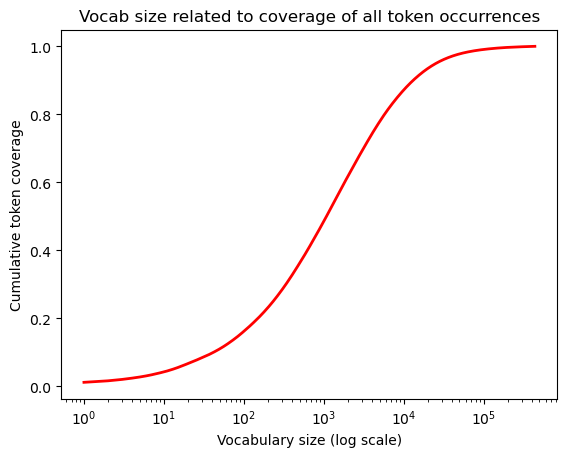

In [8]:
plt.plot(np.arange(1, len(coverage) + 1), coverage, color='red', linewidth=2)
plt.xscale('log')
plt.xlabel('Vocabulary size (log scale)')
plt.ylabel('Cumulative token coverage')
plt.title('Vocab size related to coverage of all token occurrences')
plt.show()

max_tokens fixes the size of the vocabulary to the top n most frequent tokens. When capping at 20,000 tokens, 93.5% of all words can be captured without bloating the embedding matrix. This will keep train time manageable.

In [9]:
tok_len = [len(txt.split()) for txt in X_train.tolist()]

for percentile in [50, 75, 90, 95, 99]:
    val = np.percentile(tok_len, percentile)
    print(f'{percentile}th percentile: {val:.0f} tokens')

50th percentile: 347 tokens
75th percentile: 478 tokens
90th percentile: 633 tokens
95th percentile: 740 tokens
99th percentile: 912 tokens


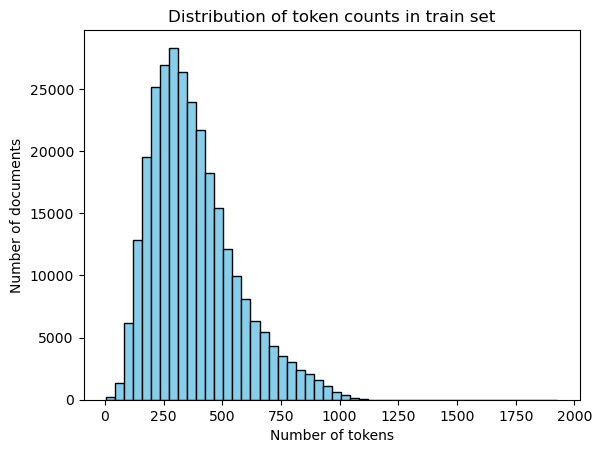

In [10]:
plt.hist(tok_len, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of token counts in train set')
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.show()

output_sequence_length truncates every text to a fixed token length. By setting it to 740 tokens, 95% of the data is covered while avoiding excessive padding on shorter texts. This helps keep training both memory and time efficient.

## Find the max_tokens and output_sequence_length for the y training labels

In [11]:
all_toks = [tok for txt in y_train.tolist() for tok in txt.split()]
tok_counter = Counter(all_toks)
freq = np.array(sorted(tok_counter.values(), reverse=True))
cumfreq = np.cumsum(freq)
coverage = cumfreq / cumfreq[-1]

In [12]:
for cutoff in [5_000, 10_000, 20_000, 50_000]:
    if cutoff <= len(coverage):
        print(f'Top {cutoff:,} tokens cover {coverage[cutoff-1]*100:.2f}% of all token uses')

Top 5,000 tokens cover 78.97% of all token uses
Top 10,000 tokens cover 88.03% of all token uses
Top 20,000 tokens cover 94.15% of all token uses
Top 50,000 tokens cover 98.19% of all token uses


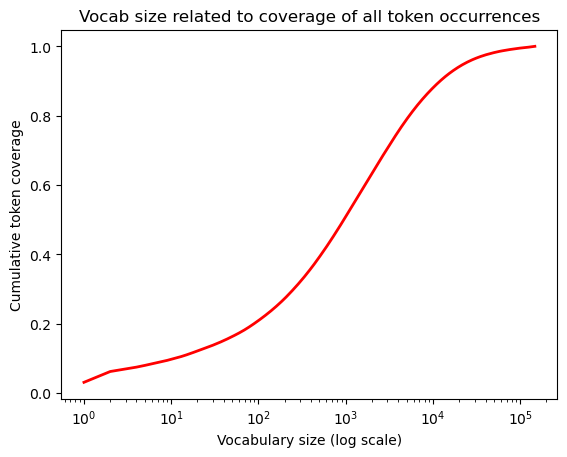

In [13]:
plt.plot(np.arange(1, len(coverage) + 1), coverage, color='red', linewidth=2)
plt.xscale('log')
plt.xlabel('Vocabulary size (log scale)')
plt.ylabel('Cumulative token coverage')
plt.title('Vocab size related to coverage of all token occurrences')
plt.show()

max_tokens fixes the size of the vocabulary to the top n most frequent tokens. When capping at 20,000 tokens, around 94% of all words can be captured without bloating the embedding matrix. This will keep train time manageable.

In [14]:
tok_len = [len(txt.split()) for txt in y_train.tolist()]

for percentile in [50, 75, 90, 95, 99]:
    val = np.percentile(tok_len, percentile)
    print(f'{percentile}th percentile: {val:.0f} tokens')

50th percentile: 31 tokens
75th percentile: 37 tokens
90th percentile: 46 tokens
95th percentile: 53 tokens
99th percentile: 69 tokens


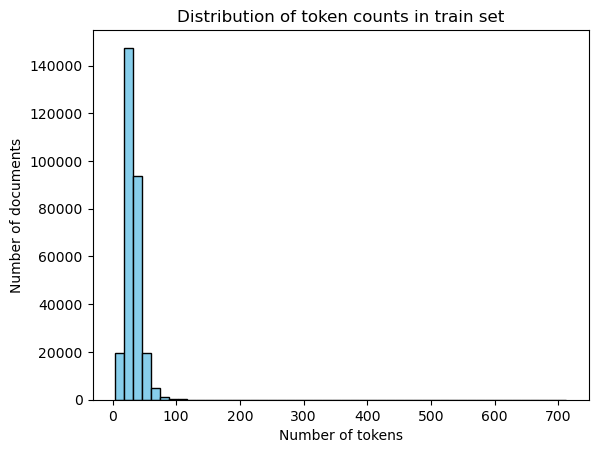

In [15]:
plt.hist(tok_len, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of token counts in train set')
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.show()

output_sequence_length truncates every text to a fixed token length. By setting it to 53 tokens, 95% of the data is covered while avoiding excessive padding on shorter texts. This helps keep training both memory and time efficient.

# Training

In [16]:
X_max_tokens = 20000
X_output_sequence_length = 740
y_max_tokens = 20000
y_output_sequence_length = 53

In [17]:
# create and fit TextVectorization layer
X_vect = TextVectorization(max_tokens=X_max_tokens, output_mode='int', output_sequence_length=X_output_sequence_length)
X_vect.adapt(X_train)

y_vect = TextVectorization(max_tokens=y_max_tokens, output_mode='int', output_sequence_length=y_output_sequence_length)
y_vect.adapt(y_train)

In [21]:
# vectorize datasets
X_train_vect = X_vect(X_train).numpy()
X_val_vect = X_vect(X_val).numpy()
X_test_vect = X_vect(X_test).numpy()

y_train_vect = y_vect(y_train).numpy()
y_val_vect = y_vect(y_val).numpy()
y_test_vect = y_vect(y_test).numpy()